## All Imports

In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Connecting to the SQLite database


In [2]:
conn = sqlite3.connect('../data/covid_data.sqlite')



In [3]:
# Executing query and returning DF
def query_db(query):
    return pd.read_sql_query(query, conn)


## Displaying all the 4 datasets being used : 

In [4]:

# facilities table
query_facilities = "SELECT * FROM facilities;"
data_facilities = query_db(query_facilities)
print("Facilities Table:")
display(data_facilities.head())


Facilities Table:


,nyt_id,facility_name,facility_type,facility_city,facility_county,facility_county_fips,facility_state,facility_lng,facility_lat,latest_inmate_population,max_inmate_population_2020,total_inmate_cases,total_inmate_deaths,total_officer_cases,total_officer_deaths,note
0,F3EFE858,Alex City Work Release prison,Low-security work release,Alex City,Coosa,1037,Alabama,-86.009015,32.904507,188.0,NaN,77,0,17,0.0,None
1,5B910220,Alabama Therapeutic Education Facility prison,State rehabilitation center,Columbiana,Shelby,1117,Alabama,-86.624067,33.180755,272.0,NaN,11,1,2,0.0,None
2,02FB1675,Bibb Correctional Facility,State prison,Brent,Bibb,1007,Alabama,-87.162781,32.920754,1725.0,1825.0,164,3,61,0.0,None
3,6378F6C4,Birmingham Women's Community Based Facility an...,State prison,Birmingham,Jefferson,1073,Alabama,-86.808344,33.531101,192.0,NaN,17,0,28,0.0,None
4,EAABF900,Bullock Correctional Facility,State prison,Bessemer,Bullock,1011,Alabama,-85.673927,32.147144,1477.0,1577.0,162,5,80,1.0,None


In [5]:

# systems table
query_systems = "SELECT * FROM systems;"
data_systems = query_db(query_systems)
print("Systems Table:")
display(data_systems.head())



Systems Table:


,system,inmate_tests,total_inmate_cases,total_inmate_deaths,latest_inmate_population,max_inmate_population_2020,total_officer_cases,total_officer_deaths
0,Alabama,15505.0,1601,64,19144.0,21900.0,1019.0,3.0
1,Alaska,27756.0,2428,5,5011.0,5143.0,85.0,0.0
2,Arizona,43652.0,12229,44,38248.0,41674.0,2739.0,0.0
3,Arkansas,0.0,11378,52,14729.0,15886.0,424.0,5.0
4,California,121207.0,49511,217,110471.0,117767.0,16090.0,26.0


In [6]:
# us_data table
query_us_data = "SELECT * FROM us_data;"
data_us_data = query_db(query_us_data)
print("US Data Table:")
display(data_us_data.head())



US Data Table:


,date,cases,deaths
0,2020-01-21,1,0
1,2020-01-22,1,0
2,2020-01-23,1,0
3,2020-01-24,2,0
4,2020-01-25,3,0


In [7]:
# us_states table
query_us_states = "SELECT * FROM us_states;"
data_us_states = query_db(query_us_states)
print("US States Table:")
display(data_us_states.head())

US States Table:


,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


## Descriptive statistics before data analysis : 

### Aggrigating the data for future analysis : 

In [8]:

# Aggregate facility data by state
facility_agg = data_facilities.groupby('facility_state').agg({
    'total_inmate_cases': 'sum',
    'latest_inmate_population': 'sum',
    'total_officer_cases': 'sum'
}).reset_index()

display(facility_agg.head())

,facility_state,total_inmate_cases,latest_inmate_population,total_officer_cases
0,Alabama,2954,25059.0,1151
1,Alaska,2360,4926.0,89
2,Arizona,20698,44404.0,868
3,Arkansas,13292,18759.0,519
4,California,75082,140390.0,19396


In [9]:
# Aggregate state data for cases
state_agg = data_us_states.groupby('state').agg({
    'cases': 'sum'
}).reset_index()

display(state_agg.head())

,state,cases
0,Alabama,895850975
1,Alaska,156619480
2,American Samoa,2704294
3,Arizona,1364935095
4,Arkansas,564075918


In [10]:
# Merge the aggregated data on state names
comparison_df = pd.merge(facility_agg, state_agg, left_on='facility_state', right_on='state', how='inner')


# Calculate case rates per 100,000 population
comparison_df['facility_case_rate'] = (comparison_df['total_inmate_cases'] / comparison_df['latest_inmate_population']) * 100000
comparison_df['state_case_rate'] = (comparison_df['cases'] / comparison_df['latest_inmate_population']) * 100000


# Filter to remove any potential infinite or NaN values due to division by zero or small populations
comparison_df = comparison_df.replace([np.inf, -np.inf], np.nan).dropna()



In [11]:
comparison_df.head(5)

,facility_state,total_inmate_cases,latest_inmate_population,total_officer_cases,state,cases,facility_case_rate,state_case_rate
0,Alabama,2954,25059.0,1151,Alabama,895850975,11788.179895,3.574967e+09
1,Alaska,2360,4926.0,89,Alaska,156619480,47909.053999,3.179445e+09
2,Arizona,20698,44404.0,868,Arizona,1364935095,46612.917755,3.073901e+09
3,Arkansas,13292,18759.0,519,Arkansas,564075918,70856.655472,3.006962e+09
4,California,75082,140390.0,19396,California,6315141921,53481.017166,4.498285e+09


In [12]:

# Calculate officer case rates
comparison_df['officer_case_rate'] = (comparison_df['total_officer_cases'] / comparison_df['latest_inmate_population']) * 100000

# Descriptive Statistics
print("Descriptive Statistics for Case Rates:")
print(comparison_df[['facility_case_rate', 'state_case_rate', 'officer_case_rate']].describe())

Descriptive Statistics for Case Rates:
       facility_case_rate  state_case_rate  officer_case_rate
count           51.000000     5.100000e+01          51.000000
mean         42513.158607     5.701703e+09        8658.314033
std          19346.435629     4.922830e+09        5339.114761
min           6645.316253     1.756759e+09           0.000000
25%          26365.933058     3.594680e+09        5236.554528
50%          41377.490434     4.348855e+09        8209.963119
75%          58485.831746     5.818227e+09       11369.664294
max          81396.724026     3.584263e+10       27845.036320


## Analysis : 

## Correlation matrix and heatmap : Analysis of Correlation Between Different Case Rates


In [13]:

# Correlation Matrix and Heatmap
correlation_matrix = comparison_df[['facility_case_rate', 'state_case_rate', 'officer_case_rate']].corr()
print("Correlation Matrix:")
print(correlation_matrix)






Correlation Matrix:
                    facility_case_rate  state_case_rate  officer_case_rate
facility_case_rate            1.000000        -0.132524           0.389576
state_case_rate              -0.132524         1.000000           0.052904
officer_case_rate             0.389576         0.052904           1.000000




The analysis of the correlation matrix provides insights into how different COVID-19 case rates are interrelated within the state:

- **Facility Case Rate and Officer Case Rate**: There is a moderate positive correlation of 0.39, indicating that when case rates increase among facility staff, they tend to also increase among inmates. This suggests shared risk factors or similar exposure levels within correctional facilities.

- **Facility Case Rate and State Case Rate**: The slight negative correlation of -0.13 implies that higher infection rates in correctional facilities do not necessarily correspond to higher rates at the state level. This might indicate that outbreaks in facilities are localized events that don't mirror broader state infection patterns.

- **Officer Case Rate and State Case Rate**: A very weak correlation of 0.05 suggests that the COVID-19 spread among correctional officers is independent of the overall state trends. This indicate unique transmission dynamics within the facilities that are not influenced by the state's general infection rates.

### Summary

The correlation analysis highlights the unique dynamics of COVID-19 spread within correctional facilities compared to broader state-level trends. The notable correlation between facility and officer case rates underscores the need for targeted interventions within these settings to control the spread of the virus. The weak correlations with state case rates emphasize that facility outbreaks might not align with state-wide trends, pointing towards the necessity of localized public health strategies.


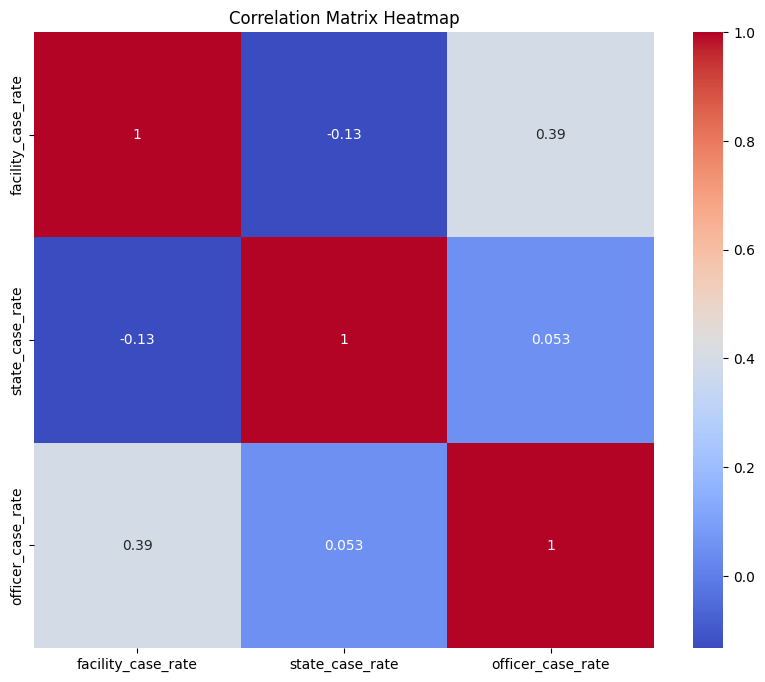

In [14]:

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.savefig('heatmap.png', bbox_inches='tight') 

plt.show()


## Time Series of Covid -19 cases for top 10 states 

**The time series graph illustrates the progression of COVID-19 cases in the ten states with the highest case counts over the course of the pandemic. This visualization allows for a clear comparison of how the virus spread differently across various highly affected states.**

#### Graph Explanation

The graph tracks the cumulative number of confirmed COVID-19 cases from the start of 2020 to mid-2023, showcasing the trends in each of the top 10 states:
- **California and Texas** show a more pronounced increase in cases, highlighting their significant challenges in controlling the spread of the virus.
- States like **Florida and New York** also demonstrate notable rises but tend to stabilize or grow at a slower rate past certain points, reflecting the effectiveness of their interventions or public health policies.
- Other states such as **Illinois, Michigan, and Ohio** show varied trends, suggesting different levels of success in managing the pandemic over time.

### Summary

This time series analysis is crucial for understanding the dynamic nature of the pandemic across the United States. By comparing the trajectories of these states, policymakers and public health officials can identify patterns and outcomes that may inform future strategies to mitigate the spread of the virus.



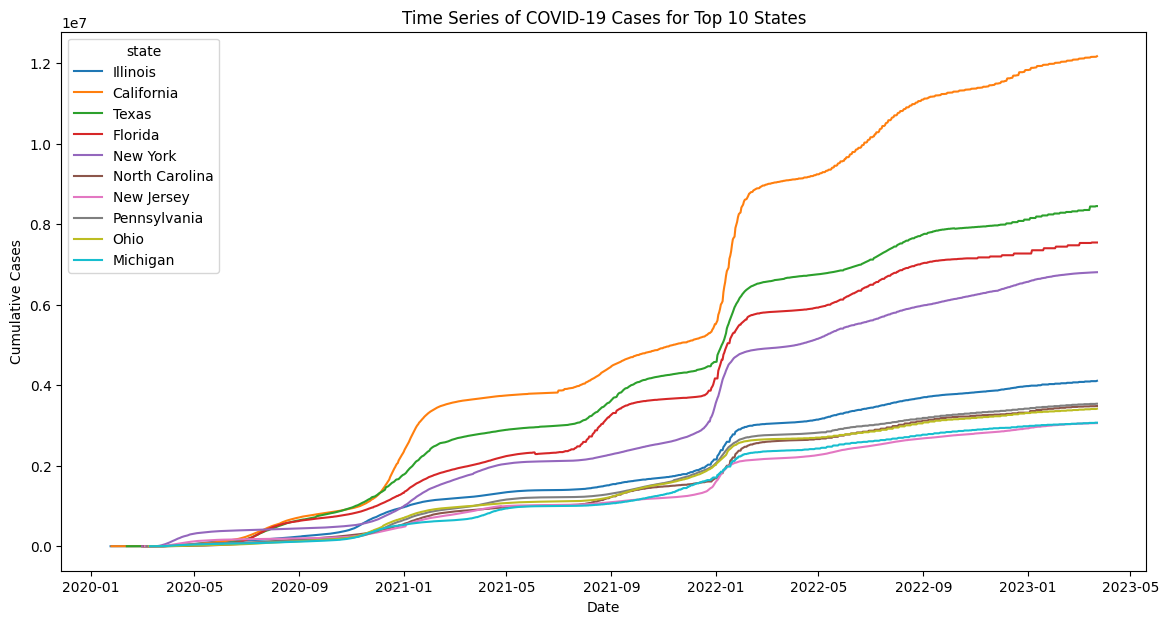

In [15]:
# Get the top 10 states by maximum cases for clearer visualization
data_us_states['date'] = pd.to_datetime(data_us_states['date'])

top_states = data_us_states.groupby('state')['cases'].max().sort_values(ascending=False).head(10).index

# Filter data to include only top states
filtered_data = data_us_states[data_us_states['state'].isin(top_states)]



plt.figure(figsize=(14, 7))
sns.lineplot(data=filtered_data, x='date', y='cases', hue='state', legend='full')
plt.title('Time Series of COVID-19 Cases for Top 10 States')
plt.xlabel('Date')
plt.ylabel('Cumulative Cases')
plt.savefig('timeSeries.png', bbox_inches='tight')  

plt.show()



This graph shows us how the number of COVID-19 cases has changed over time in the states with the most cases. By looking at this, we can see:
- **California and Texas** had a lot of cases and they kept going up fast.
- In **Florida and New York**, cases also went up but later started to increase more slowly, which might show that what they did to stop the virus was working at some point.
- Other states like **Illinois, Michigan, and Ohio** had different patterns, showing us that each state faced unique challenges and had different results with their efforts to control the virus.

By watching how cases rose in these states, we can learn what might work best to stop the virus in the future or in different places.


## Comparision between inmates and officers : 

In [16]:
# Calculate case rates per 100,000 for inmates and officers
comparison_df['inmate_case_rate'] = (comparison_df['total_inmate_cases'] / comparison_df['latest_inmate_population']) * 100000
comparison_df['officer_case_rate'] = (comparison_df['total_officer_cases'] / comparison_df['latest_inmate_population']) * 100000

This bar chart provides a comparative analysis of COVID-19 case rates per 100,000 population between inmates and correctional officers across various states. The visual underscores the disparities in infection rates, highlighting the higher vulnerability and exposure risk faced by inmates compared to officers.

#### Graph Explanation

- The **blue bars** represent the COVID-19 case rates among inmates, which are noticeably higher in most states compared to the **green bars**, which indicate the case rates among officers.
- States like **California, Texas, and Florida** show significant differences in case rates between inmates and officers, emphasizing the severe impact of COVID-19 within inmate populations.
- The visual suggests that inmates, likely due to conditions such as overcrowding and limited access to preventive health measures, experience higher rates of infection compared to the staff.

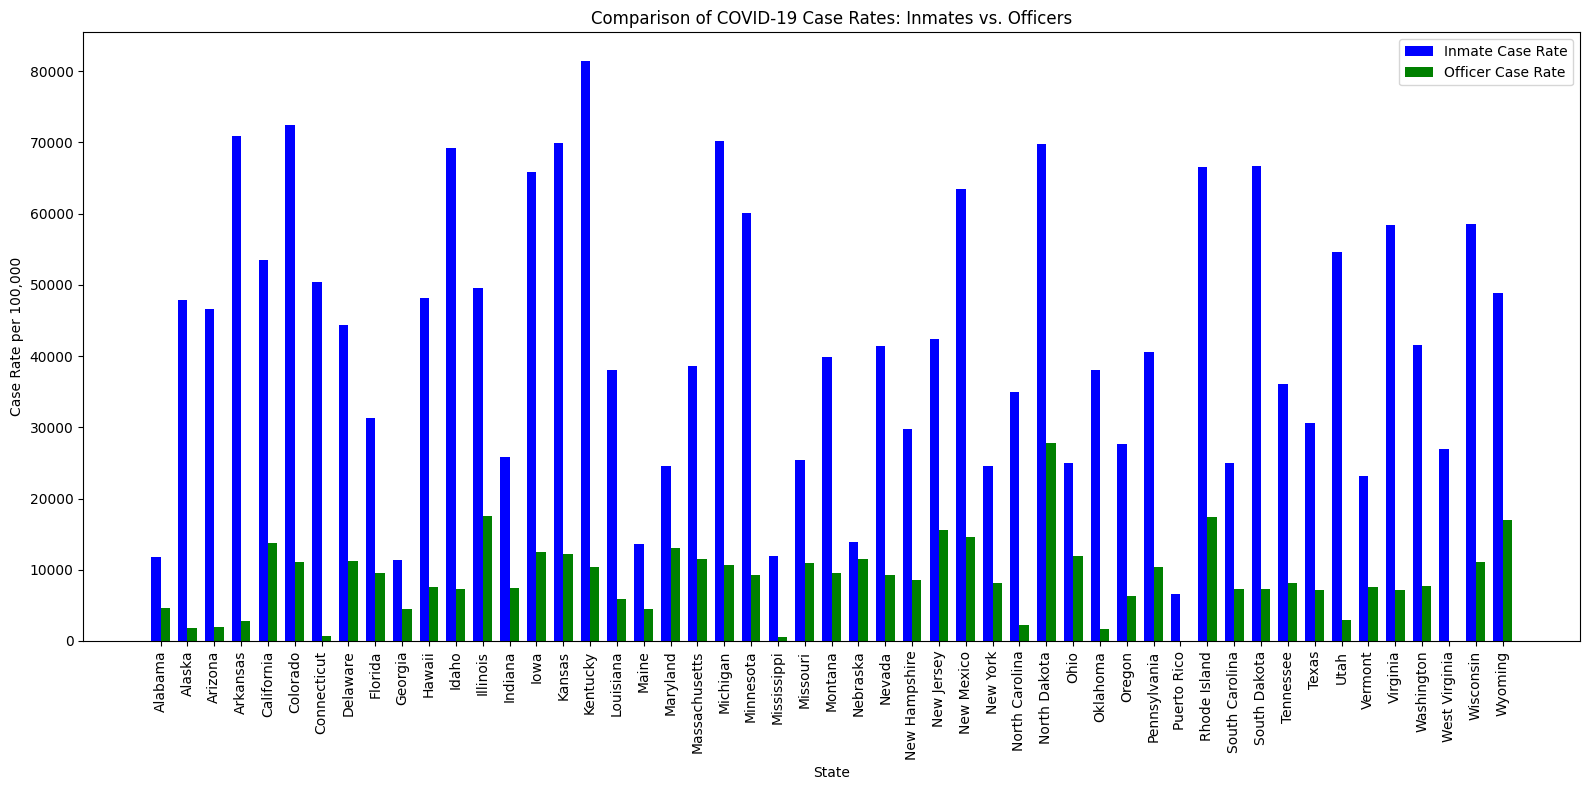

In [17]:
# Create a plot
plt.figure(figsize=(16, 8))
index = np.arange(len(comparison_df['facility_state']))
bar_width = 0.35

plt.bar(index, comparison_df['inmate_case_rate'], bar_width, label='Inmate Case Rate', color='blue')
plt.bar(index + bar_width, comparison_df['officer_case_rate'], bar_width, label='Officer Case Rate', color='green')

plt.xlabel('State')
plt.ylabel('Case Rate per 100,000')
plt.title('Comparison of COVID-19 Case Rates: Inmates vs. Officers')
plt.xticks(index + bar_width / 2, comparison_df['facility_state'], rotation=90)
plt.legend()
plt.tight_layout()
plt.savefig('comparision.png', bbox_inches='tight') 

plt.show()



**Insight: Below graph clearly shows that COVID-19 infection rates are significantly higher among inmates than officers across nearly all states. This could be indicative of the environmental conditions within facilities that may facilitate the spread of infections more readily among inmates.**
####  Summary

This analysis is crucial for understanding the health disparities within correctional facilities and can help in providing better health policies and protective measures specifically tailored for inmates to control and prevent the spread of infectious diseases.


## Analysis of Facility Cases to State Cases Ratio



This analysis depicts the ratio of COVID-19 cases found within correctional facilities compared to the total cases recorded in each state. The chart uses a vertical bar representation where each bar corresponds to a state, scaled by the ratio of facility cases to state cases.

#### Interpretations from the Graph:
- **High Ratios:** States like Arkansas, which exhibit very high ratios, indicate that a significant portion of their COVID-19 burden is concentrated within correctional facilities. This could point to critical outbreaks within prisons or jails that might require immediate public health interventions.
- **Low Ratios:** States such as Puerto Rico, with very low ratios, show that COVID-19 cases in correctional facilities constitute a small fraction of the state's total cases, possibly indicating effective containment within these facilities or higher case numbers in the general population.

#### Conclusion:
The graph is instrumental in highlighting how COVID-19 impacts correctional facilities differently across states, underscoring the need for tailored approaches in managing outbreaks in such high-risk settings.


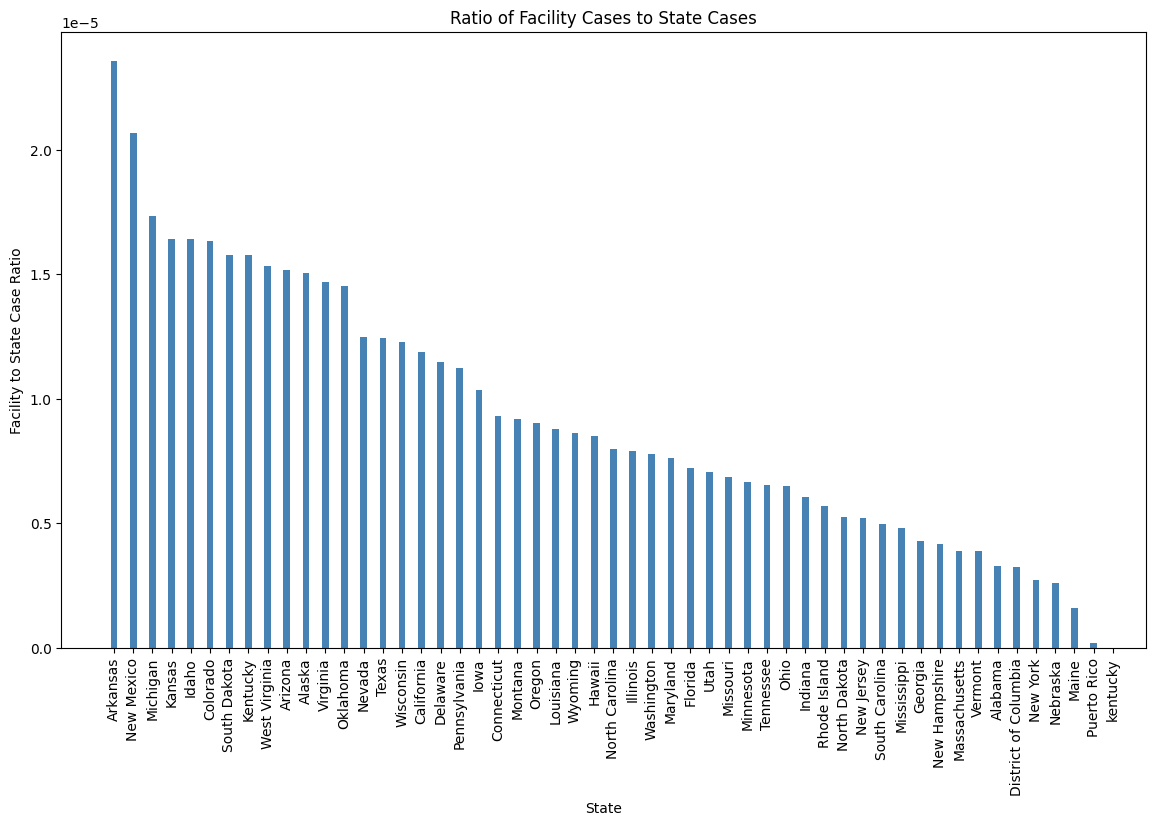

In [18]:
# Aggregate to get total cases per state
state_cases_agg = data_us_states.groupby('state')['cases'].sum().reset_index()

# Merge state data with facilities aggregate data
comparison_df = facility_agg.merge(state_cases_agg, left_on='facility_state', right_on='state', how='left')

# Calculate the ratio of facility cases to state cases
comparison_df['facility_to_state_case_ratio'] = comparison_df['total_inmate_cases'] / comparison_df['cases']
comparison_df_sorted = comparison_df.sort_values(by='facility_to_state_case_ratio', ascending=False)
# Visualization
positions = np.arange(len(comparison_df_sorted['facility_state']))
width = 0.35
fig, ax = plt.subplots(figsize=(14, 8))
bars = ax.bar(comparison_df_sorted['facility_state'], comparison_df_sorted['facility_to_state_case_ratio'], width, color='steelblue')

ax.set_xlabel('State')
ax.set_ylabel('Facility to State Case Ratio')
ax.set_title('Ratio of Facility Cases to State Cases')
ax.set_xticks(positions)
ax.set_xticklabels(comparison_df_sorted['facility_state'], rotation=90)
plt.savefig('ratio.png', bbox_inches='tight')  

plt.show()




In [19]:
conn.close()